# CPSC 8650 - DATA MINING PROJECT
## Predicting Hearing Thresholds from Brain MRI Scans

**GROUP 4**<br>
**MEMBERS:** Charanjit Singh, Parampreet Singh, Tejashree Challagundla

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
#LIBRARIES
import pandas as pd
import nibabel as nib
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectKBest, f_regression 
from xgboost import XGBRegressor

In [11]:
len(tf.config.list_physical_devices('GPU'))

1

### Data Preparation:

* Process the MRI gray matter images to a consistent format suitable for deep learning models.
* Extract and prepare the hearing threshold data for the prediction task.

In [12]:
# Load the dataset from the provided Excel file
labels_path = "C:\\Users\\chara\\OneDrive\\Desktop\\DM\\threshold_labels.csv"

# Load the dataset from the Excel file
threshold_labels = pd.read_csv(labels_path)  # This assumes the required data is in the first sheet

# Display the first few rows of the dataset to understand its structure
print(threshold_labels.head(10))

           ID  PT500  PT4000
0  smwp1_0001     25      73
1  smwp1_0002      5      10
2  smwp1_0003      5      45
3  smwp1_0004      5      15
4  smwp1_0005      3      63
5  smwp1_0006     10      18
6  smwp1_0007     10      38
7  smwp1_0008     18      45
8  smwp1_0009      8      83
9  smwp1_0010     15      53


In [13]:
threshold_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      171 non-null    object
 1   PT500   171 non-null    int64 
 2   PT4000  171 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.1+ KB


#### Processing MRI Scans

For the MRI scans, we'll need to:

* **Standardize Image Size:** Ensure all images are of the same dimensionality for model input.
* **Normalization:** MRI scans should be normalized to have similar intensity ranges, enhancing model training efficiency.

In [14]:
def load_nii_to_np(folder_path, new_shape=(96, 96, 96)):
    # List to hold all MRI scans
    scans = []

    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.nii'):
            file_path = os.path.join(folder_path, filename)

            # Load the MRI scan
            scan = nib.load(file_path)

            # Convert the scan into a numpy array
            scan_data = scan.get_fdata().astype(np.float32)
            scan_data = scan_data[:, 50:90, :] #[:, 50:80, :]

            # Normalize the scan data
            normalized_scan = (scan_data - np.min(scan_data)) / (np.max(scan_data) - np.min(scan_data))
            data_shape = normalized_scan.shape

            # Resize the scan to add a dimension for grayscale channel
            resized_scan = np.expand_dims(normalized_scan, axis=-1)

            # Add the preprocessed scan to the list
            scans.append(resized_scan)

    # Stack all scans into a single np stack
    scans_np = np.stack(scans)

    return scans_np, data_shape

# Path to the folder containing the MRI scans
mri_scan_folder_path = "C:\\Users\\chara\\OneDrive\\Desktop\\DM\\dataset\\n171_smwp1"

# Load the MRI scans into a np stack
mri_scans_np, data_shape = load_nii_to_np(mri_scan_folder_path)
data_shape += (1, )

# Display the shape of the stack
print(mri_scans_np.shape)

print(data_shape)

(171, 113, 40, 113, 1)
(113, 40, 113, 1)


#### Splitting the data into train-test and then normalizing it

In [15]:
labels_np = threshold_labels[['PT4000', 'PT500']].to_numpy()

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    mri_scans_np, labels_np, test_size=0.2, random_state=42
)

# Data augmentation by simply stacking the data 5 times
X_train = np.concatenate([X_train, X_train, X_train, X_train, X_train], axis=0)
y_train = np.concatenate([y_train, y_train, y_train, y_train, y_train], axis=0)

# Flatten the 3D MRI images into 1D vectors
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

### Model Development

#### MODEL 1: Convolutional Neural Network

Epoch 1/60
544/544 [==============================] - 52s 76ms/step - loss: 429.7457 - val_loss: 350.7896
Epoch 2/60
544/544 [==============================] - 41s 75ms/step - loss: 404.8020 - val_loss: 266.9575
Epoch 3/60
544/544 [==============================] - 41s 75ms/step - loss: 371.0179 - val_loss: 254.3205
Epoch 4/60
544/544 [==============================] - 42s 77ms/step - loss: 353.6087 - val_loss: 236.5712
Epoch 5/60
544/544 [==============================] - 41s 76ms/step - loss: 307.1413 - val_loss: 197.1069
Epoch 6/60
544/544 [==============================] - 41s 76ms/step - loss: 293.7420 - val_loss: 210.9852
Epoch 7/60
544/544 [==============================] - 41s 76ms/step - loss: 273.7940 - val_loss: 151.6053
Epoch 8/60
544/544 [==============================] - 41s 76ms/step - loss: 274.2768 - val_loss: 142.0759
Epoch 9/60
544/544 [==============================] - 41s 76ms/step - loss: 258.9000 - val_loss: 124.1937
Epoch 10/60
544/544 [=========================

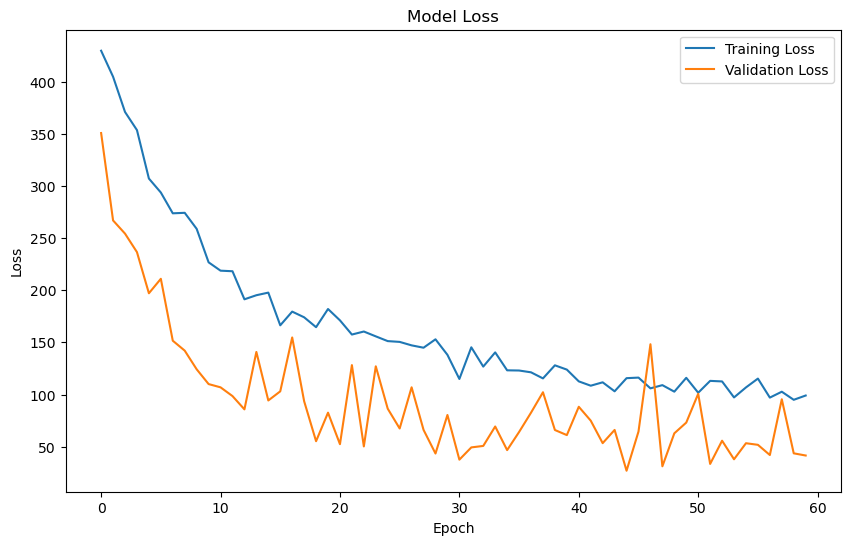

In [16]:
def build_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),

        Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Conv3D(256, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Flatten(),
        Dense(256, activation='relu',  kernel_regularizer=l2(0.03)),
        Dropout(0.5),

        Dense(128, activation='relu',  kernel_regularizer=l2(0.03)),
        Dropout(0.5),

        Dense(2, activation='linear')
    ])    

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-5,
        decay_steps=10000,
        decay_rate=0.9)
   
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mean_squared_error')
    return model

# Convert the datasets and labels into TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Define a batch size
batch_size = 1

# Batch the training dataset
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Calculate the number of batches to use for validation
val_size = int(0.2 * len(X_train) / batch_size)

# Create training and validation datasets
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

# Create and compile the CNN model
cnn_model = build_cnn_model(data_shape)  # Including the channel dimension

# cnn_model, early_stopping_callback = build_cnn_model(input_shape=(data_shape))

# Fit the model to the training data using the dataset loader
history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=60)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

1/1 [==============================] - 1s 604ms/step
Predicted value: [42.30235  11.128555]
Actual value: [40 18]


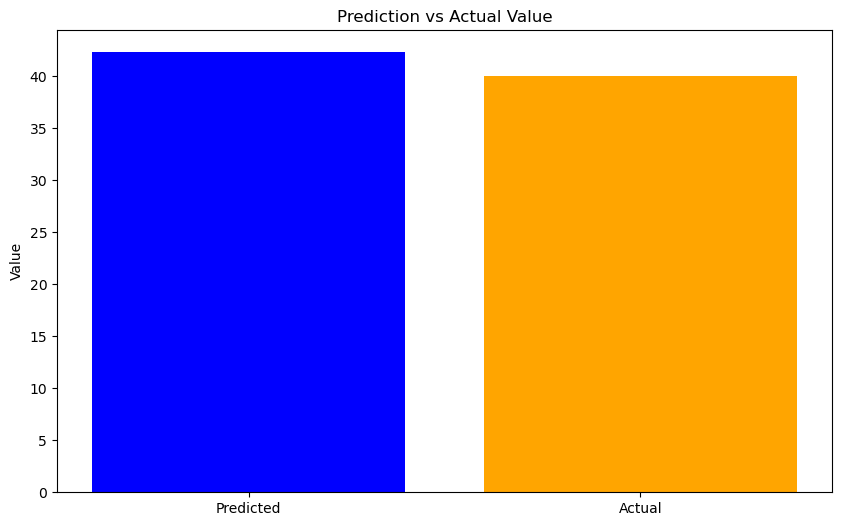

In [32]:
# Assuming ny_index is the index of the NY value in the X_test set
ny_index = 2

# Replace 0 with the actual index of the NY value you're interested in

# Select the specific test sample and its actual label
ny_sample = X_test[ny_index]
ny_actual_label = y_test[ny_index]

# Since the model expects a batch, we need to add an extra dimension
ny_sample_expanded = np.expand_dims(ny_sample, axis=0)

# Predict using the model
ny_prediction = cnn_model.predict(ny_sample_expanded)

# Print the predicted and actual values
print(f"Predicted value: {ny_prediction.flatten()}")
print(f"Actual value: {ny_actual_label}")

# Visualizing the prediction and actual value
plt.figure(figsize=(10, 6))
plt.bar(['Predicted', 'Actual'], [ny_prediction.flatten()[0], ny_actual_label[0]], color=['blue', 'orange'])
plt.ylabel('Value')
plt.title('Prediction vs Actual Value')
plt.show()

#### MODEL 2: Support Vector Machine (SVM) with PCA Script

In [18]:
def train_svm_with_pca_per_target(X, y, n_components=10):
    # y should be of shape [n_samples, n_targets]
    models = []
    for i in range(y.shape[1]):  # Assuming y has shape [n_samples, n_targets]
        pipeline = make_pipeline(PCA(n_components=n_components), SVR(C=1.0, epsilon=0.2))
        pipeline.fit(X, y[:, i])
        models.append(pipeline)
    return models

# Train a separate model for each target
svm_model = train_svm_with_pca_per_target(X_train_flattened, y_train)

Predicted values: [22.243050830990008, 6.094474995437929]
Actual values: [20  5]


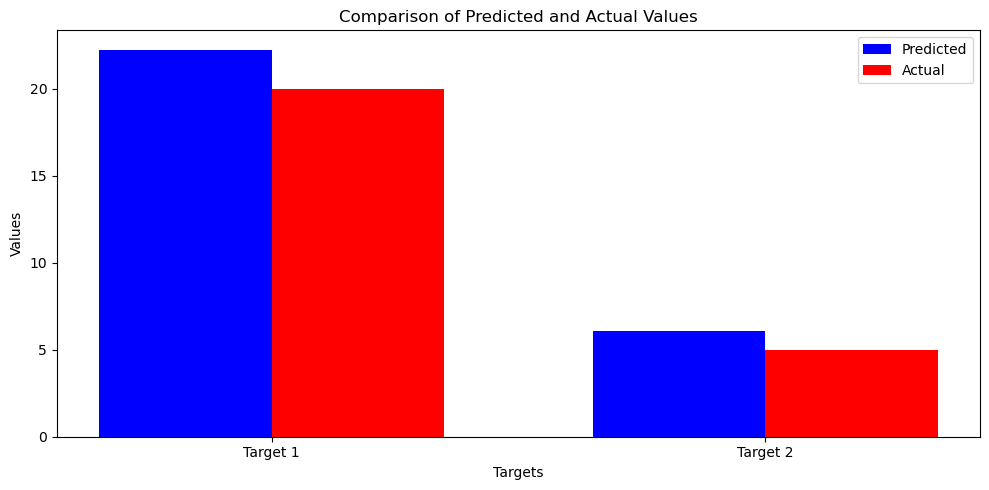

In [19]:
# Assuming ny_index is the index of the specific test value you're interested in
ny_index = 3  # You can replace 3 with any valid index from your test set

# Select the specific test sample
ny_sample = X_test_flattened[ny_index]  # Ensure this is the flattened version if that's how the model was trained

# Predict using each model. Since each model expects a single instance to be a 2D array:
ny_predictions = [model.predict(ny_sample.reshape(1, -1))[0] for model in svm_model]

# Assuming you have the actual labels for comparison
ny_actual_labels = y_test[ny_index]

# Print the predicted and actual values
print("Predicted values:", ny_predictions)
print("Actual values:", ny_actual_labels)

# Number of targets
num_targets = len(ny_predictions)

# Plotting predicted vs actual values
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(num_targets)

plt.bar(index, ny_predictions, bar_width, label='Predicted', color='b')
plt.bar(index + bar_width, ny_actual_labels, bar_width, label='Actual', color='r')

plt.xlabel('Targets')
plt.ylabel('Values')
plt.title('Comparison of Predicted and Actual Values')
plt.xticks(index + bar_width / 2, ('Target 1', 'Target 2'))  # Adjust labels as needed
plt.legend()

plt.tight_layout()
plt.show()

#### MODEL 3: XGBOOST 

In [20]:
# Feature selection for dimensionality reduction
def select_features(X_train, y_train, X_test, k=10):

    # Create empty masks to combine feature selection from each target
    combined_mask = np.zeros(X_train.shape[1], dtype=bool)

    # Perform feature selection for each target variable
    for i in range(y_train.shape[1]):
        # Select the best k features for the i-th target
        selector = SelectKBest(score_func=f_regression, k=k)
        X_new = selector.fit_transform(X_train, y_train[:, i])

        # Combine the masks (logical OR)
        combined_mask = combined_mask | selector.get_support()

    # Apply the combined mask to the training and testing sets
    X_train_selected = X_train[:, combined_mask]
    X_test_selected = X_test[:, combined_mask]

    return X_train_selected, X_test_selected, combined_mask

# Perform feature selection
X_train_selected, X_test_selected, feature_mask = select_features(
    X_train_flattened, y_train, X_test_flattened, k=9
)

# Define a set of hyperparameters to tune
param_grid = {
    'estimator__max_depth': [3, 4, 5],
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.7, 0.8, 0.9],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9],
}

# Set up the XGBoost model inside MultiOutputRegressor
xgboost_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror'))

# Set up GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_selected, y_train)  # Use X_train_selected if you did feature selection, else X_train_flattened

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best model
xgboost_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best hyperparameters: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 200, 'estimator__subsample': 0.7}


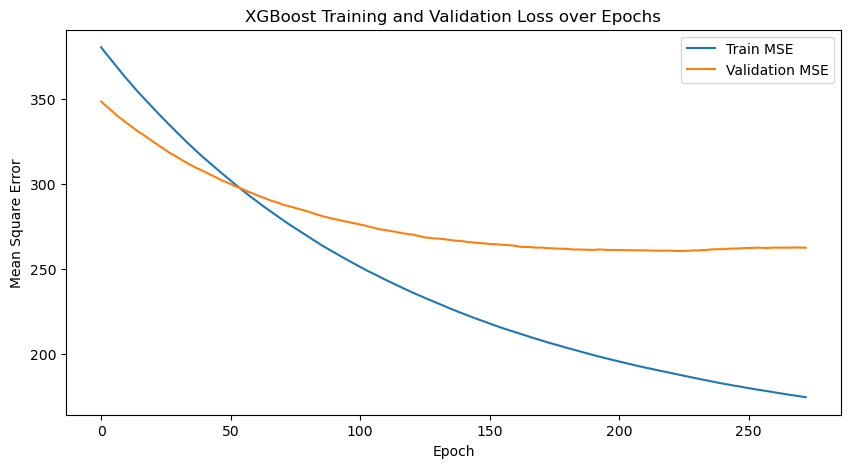

In [31]:
from xgboost import XGBRegressor, DMatrix, train
import matplotlib.pyplot as plt
import math

# Assuming you already have X_train_selected, y_train, X_test_selected, y_test properly set up
# Create DMatrix for train and validation
dtrain = DMatrix(X_train_selected, label=y_train)
dval = DMatrix(X_test_selected, label=y_test)  # Here using test data as validation for illustration

# Define parameters (using previously identified or default reasonable values)
params = {
    'max_depth': 2,  # Reduced depth to simplify each tree
    'learning_rate': 0.005,  # Further reduced to ensure more gradual learning
    'subsample': 0.6,  # Reduced to lower the fraction of samples used per tree
    'colsample_bytree': 0.6,  # Reduced to lower the fraction of features used per tree
    'objective': 'reg:squarederror',
    'reg_alpha': 0.05,  # Increased L1 regularization to promote sparsity
    'reg_lambda': 2.5,  # Increased L2 regularization to add more penalty on model complexity
    'booster': 'dart'  # DART booster to help reduce overfit
}

# Add early stopping
evals_result = {}
model = train(params, dtrain, num_boost_round=2000, evals=[(dtrain, 'train'), (dval, 'eval')],
              early_stopping_rounds=50, evals_result=evals_result, verbose_eval=False)

# Extract the training and validation loss
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['eval']['rmse']

train_mse = [value ** 2 for value in train_rmse]
val_mse = [value ** 2 for value in val_rmse]

# Plotting the training and validation loss graph
plt.figure(figsize=(10, 5))
plt.plot(x_axis, train_mse, label='Train MSE')
plt.plot(x_axis, val_mse, label='Validation MSE')
plt.title('XGBoost Training and Validation Loss over Epochs')
plt.legend()
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.show()


Predicted value: [27.52304  12.680429]
Actual value: [25 13]


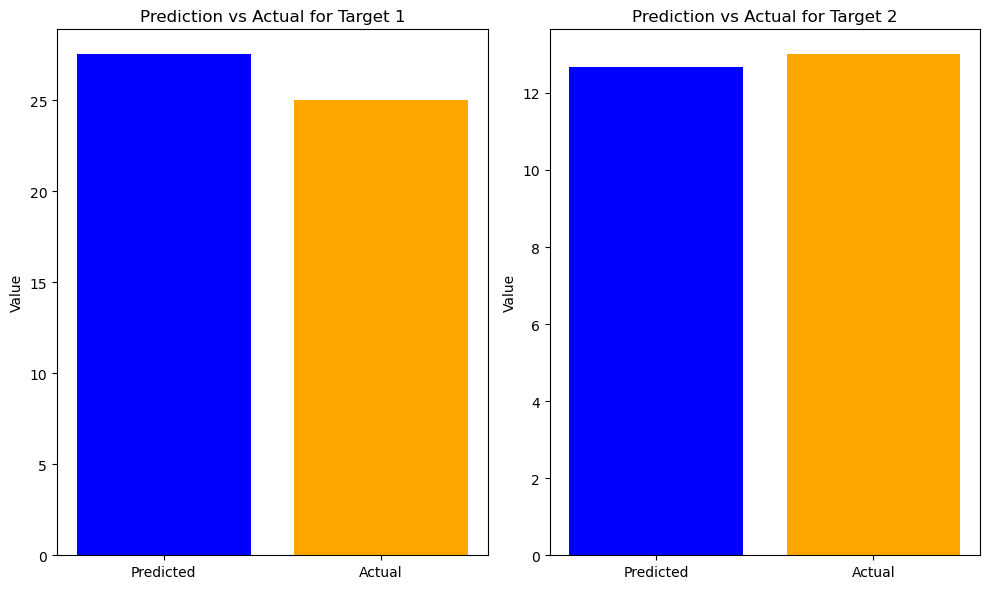

In [41]:
# Assuming `ny_index` is the index of the specific test value you're interested in
ny_index = 8  # You can replace 3 with any valid index from your test set

# Select the specific test sample and its actual labels
ny_sample = X_test_selected[ny_index]
ny_actual_label = y_test[ny_index]

# Since the model doesn't require the input to have a batch dimension,
# you should still ensure the input is two-dimensional (1, number of features)
ny_sample_expanded = ny_sample.reshape(1, -1)

# Predict using the model
ny_prediction = xgboost_model.predict(ny_sample_expanded)

# Print the predicted and actual values
print("Predicted value:", ny_prediction[0])
print("Actual value:", ny_actual_label)

# Visualizing the prediction and actual value for each target
plt.figure(figsize=(10, 6))
num_targets = ny_prediction.shape[1]  # Should be 2 based on your setup
for i in range(num_targets):
    plt.subplot(1, num_targets, i + 1)
    plt.bar(['Predicted', 'Actual'], [ny_prediction[0][i], ny_actual_label[i]], color=['blue', 'orange'])
    plt.title(f'Prediction vs Actual for Target {i+1}')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

### Evaluation

In [23]:
def evaluate_model(model, X_test, y_test, model_type='cnn'):
    """
    Evaluate the given model on the test set.

    Parameters:
    - model: The trained model (CNN, SVM pipeline list, or XGBoost).
    - X_test: Test set images or features.
    - y_test: True hearing thresholds for the test set.
    - model_type: Type of the model ('cnn', 'svm', or 'xgboost').

    Returns:
    - MAE: Mean Absolute Error of the predictions.
    - MSE: Root Mean Squared Error of the predictions.
    """
    # Initialize predictions array
    predictions = None

    # Preprocess test data based on model type
    if model_type == 'cnn':
        predictions = model.predict(X_test)

    elif model_type == 'svm':
        # Ensure X_test is appropriately shaped (flattened if needed)
        if len(X_test.shape) > 2:
            X_test_flattened = np.reshape(X_test, (X_test.shape[0], -1))
        else:
            X_test_flattened = X_test
        
        # Aggregate predictions from each model in the list
        predictions = np.column_stack([mod.predict(X_test_flattened) for mod in model])

    elif model_type == 'xgboost':
        predictions = model.predict(X_test)

    else:
        raise ValueError("Unsupported model type. Choose 'cnn', 'svm', or 'xgboost'.")

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)  # Use squared=False if you need RMSE

    return mae, mse

test_dataset = tf.data.Dataset.from_tensor_slices((X_test))
test_dataset = test_dataset.batch(batch_size)

mae, mse = evaluate_model(cnn_model, test_dataset, y_test, model_type='cnn')
print(f"CNN Model - MAE: {mae}, MSE: {mse}")

mae, mse = evaluate_model(svm_model, X_test_flattened, y_test, model_type='svm')
print(f"SVM Model - MAE: {mae}, MSE: {mse}")

mae, mse = evaluate_model(xgboost_model, X_test_selected, y_test, model_type='xgboost')
print(f"xgboost Model - MAE: {mae}, MSE: {mse}")

35/35 [==============================] - 1s 20ms/step
CNN Model - MAE: 11.23733310018267, MSE: 230.08263556371926
SVM Model - MAE: 12.459703497190832, MSE: 244.3327747137499
xgboost Model - MAE: 14.381235516071321, MSE: 338.47099563145787
